# Проект разработки стратегии взаимодействия с клиентами на основе аналитических данных сети фитнес-центров «Культурист-датасаентист»

## План проекта:

1. Загрузить данные и познакомитсья с ними.      
  
2. Провести исследовательсикй анализ данных:
- найти пропуски, изучить средние и стандартные отклонения 
- сравнить средние значения в двух группах (кто ушел в отток и кто остался)
- построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
- построить матрицу корреляций и отобразить ее

3. Построить модель прогнозирования оттока клиентов:
- разбить данные на обучающую и валидационную выборку
- обучить модель на train-выборке двумя способами (логистической регрессией и случайным лесом)
- оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели.

4. Сделать кластеризацию клиентов:
- стандартизировать данные
- построить матрицу расстояний на стандартизованной матрице признаков и нарисовать дендрограмму
- обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов
- оценить средние значения признаков для кластеров
- построить распределения признаков для кластеров
- посчитать долю оттока для каждого полученного кластера

5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами.

## Шаг 1. Загрузим данные и проведем предобработку

In [64]:
# загрузим нужные библиотеки
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans
import itertools

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve

In [2]:
# прочитаем файл
gym_churn = pd.read_csv("C:\\Users\\alekl\\Documents\\Практикум\\gym_churn.csv")
gym_churn.head()
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Прочитали файл и сохранили егов переменной. Ознакомились с данными. Для удобства подправим названия некоторых столбцов.

In [3]:
gym_churn = gym_churn.rename(columns = {'Near_Location': 'near_location', 'Partner':'partner', 'Promo_friends':'promo_friends', 'Phone':'phone', 'Contract_period':'contract_period', 'Group_visits':'group_visits', 'Age':'age', 'Avg_additional_charges_total':'avg_additional_charges_total', 'Month_to_end_contract':'month_to_end_contract', 'Lifetime':'lifetime', 'Avg_class_frequency_total':'avg_class_frequency_total', 'Avg_class_frequency_current_month':'avg_class_frequency_current_month','Churn':'churn' })
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Проверим датасет на пропуски, изучим средние значения и стандартные отклонения.**

In [4]:
# посмотрим есть ли пропуски
gym_churn.duplicated().sum()

0

Дубликаты отсутствуют.

In [5]:
# посмотрим на средние значения в датасете
gym_churn.mean().round(3)

gender                                 0.510
near_location                          0.845
partner                                0.487
promo_friends                          0.308
phone                                  0.904
contract_period                        4.681
group_visits                           0.412
age                                   29.184
avg_additional_charges_total         146.944
month_to_end_contract                  4.323
lifetime                               3.725
avg_class_frequency_total              1.879
avg_class_frequency_current_month      1.767
churn                                  0.265
dtype: float64

Вывели средние значения. Результаты столбцов gender,near_location, partner, promo-friends, phone, group_visits, churn не будем рассматривать, так как это бинарные значения. Значения столбца взраста также не будет рассматривать, потому что среднее значение не свосем верно отражает действительность. Также пропустим анализ длительности действующего абонемента, у него присутствуют только определенные числовые значения. 

Может сделать следующие выводы:
- время с момента первого обращения в фитнес-центр в среднем составляет 3-4 месяца
- срок до окончания действующего абонемента составляет около 4 месяцев
- среднее от среднего частоты посещений в неделю за все время с начала действия абонемента сотавляет 1-2
- среднее от средней частоты посещений в неделю за предыдущий месяц - 1-2
- суммарная выручка от других услуг центра примерно 147

In [6]:
# посмотрим на стандартные отклонения
gym_churn.describe()

gender  near_location      partner  promo_friends        phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       contract_period  group_visits          age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       avg_additional_charges_total  month_to_end_contract     lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       avg_class_frequency_total  avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

Проанализируем возможные данные. Стандартное отклонение времени с момента первого обращения составляет 3-4 месяца, срок до окончания действующего абонемента составляет около 4 месяцев, среднее от среднего частоты посещений в неделю за все время с начала действия абонемента сотавляет около 1, среднее от средней частоты посещений в неделю за предыдущий месяц - 1 и суммарняая выручка от других услуг центра - 96.

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался**

In [7]:
# создадим датасет с группой оттока
gym_churn_users = gym_churn[gym_churn['churn'] == 1]
gym_churn_users.mean()

gender                                 0.510839
near_location                          0.768143
partner                                0.355325
promo_friends                          0.183789
phone                                  0.902922
contract_period                        1.728558
group_visits                           0.268615
age                                   26.989632
avg_additional_charges_total         115.082899
month_to_end_contract                  1.662582
lifetime                               0.990575
avg_class_frequency_total              1.474995
avg_class_frequency_current_month      1.044546
churn                                  1.000000
dtype: float64

In [8]:
# создадим датасет с группой оставшихся
gym_users = gym_churn[gym_churn['churn'] == 0]
gym_users.mean()

gender                                 0.510037
near_location                          0.873086
partner                                0.534195
promo_friends                          0.353522
phone                                  0.903709
contract_period                        5.747193
group_visits                           0.464103
age                                   29.976523
avg_additional_charges_total         158.445715
month_to_end_contract                  5.283089
lifetime                               4.711807
avg_class_frequency_total              2.024876
avg_class_frequency_current_month      2.027882
churn                                  0.000000
dtype: float64

**Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался**

Построим круговую диаграмму разделения на женщин и мужчин.

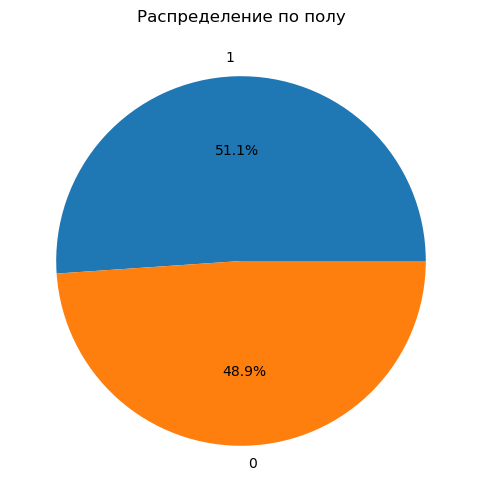

In [9]:
# подсчитываем количество мужчин и женщин
counts_gender = gym_churn_users['gender'].value_counts()

# даем названия
labels = counts_gender.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_gender, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по полу')
plt.show()

Так, как мы не знаем, что подразумеваяется по значениями 0 и 1, нельяз сделать выводы о преобладании определенного пола. Разделение незначительное, поэтому эти данные не особо нам помогут.

Построим диаграмму распределения живущих или работающих в районе фитнес-центра и нет.

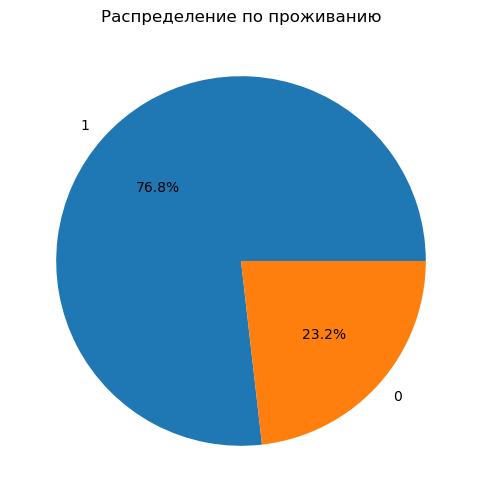

In [10]:
# подсчитываем количество проживающих рядом и нет
counts_near = gym_churn_users['near_location'].value_counts()

# даем названия
labels = counts_near.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_near, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по проживанию')
plt.show()

Видим, что большинство (76,8%) проживает или работает в том же районе, где и находится фитнес-центр. Это неудивительно. Расстояние до дома/работы чаще всего является важным критерием при выборе тренажерного зала.

Построим распределение по сотрудникам компании-партнёра клуба.

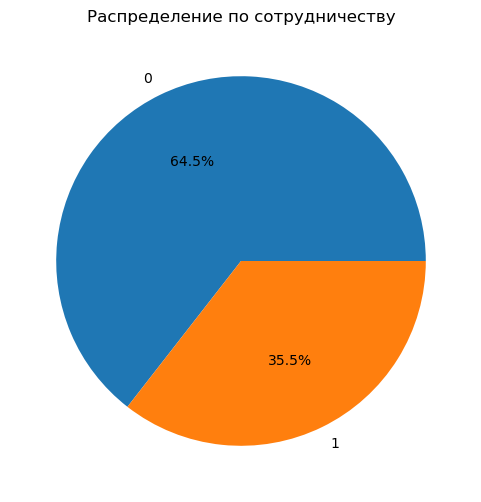

In [11]:
# подсчитываем количество сотрудников компании-партнера клуба
counts_partner = gym_churn_users['partner'].value_counts()

# даем названия
labels = counts_partner.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_partner, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по сотрудничеству')
plt.show()

Как видим на графике, большинство клиентов не являются сотрудниками компании - 64,5%.

Теперь посмотрим на распределение по использованию промокода.

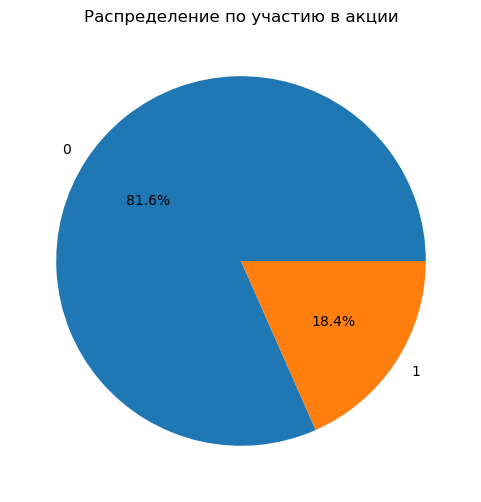

In [12]:
# подсчитываем количество клиентов, использовавших промокод
counts_promo = gym_churn_users['promo_friends'].value_counts()

# даем названия
labels = counts_promo.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_promo, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по участию в акции')
plt.show()

Оказалось, что большинство клиентов - 81,6% не участвовали в промоакции. 

Проверим распределдение по наличию контактного телефона.

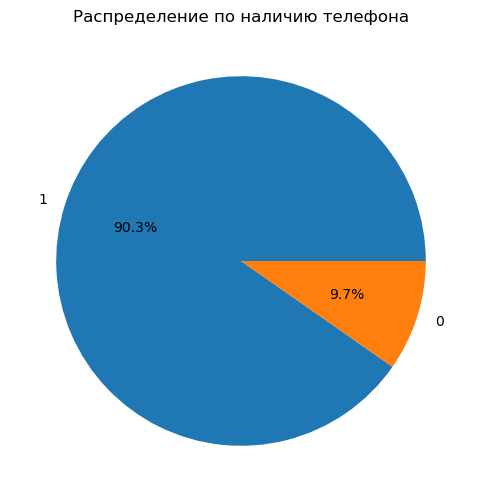

In [13]:
# подсчитываем количество клиентов с наличием контактного телефона
counts_phone = gym_churn_users['phone'].value_counts()

# даем названия
labels = counts_phone.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_phone, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по наличию телефона')
plt.show()

Практически все клиенты оставили данных о наличие контактного телефона - 90,3%.

Построим график распределения по возрасту.

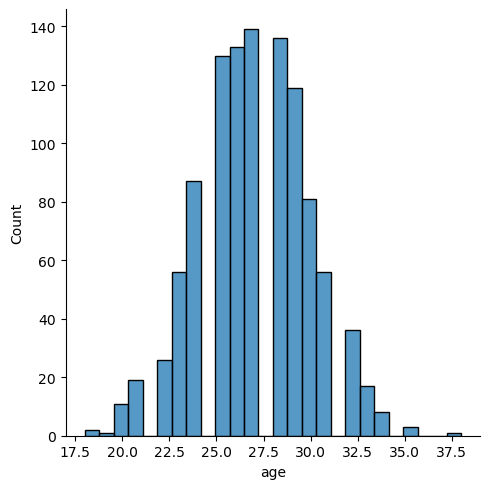

In [14]:
sns.displot(gym_churn_users['age'])

Как видим, больше всего людей в возрасте 25-27 лет.

Посмотрим распределение по времени обращению в фитнес-центр.

In [47]:
sns.displot(gym_churn_users['lifetime'])

Как видим на графике, время обращения в фитнес-центр составляет чаще всего меньше месяца или 1 месяц.

Посмотрим на длительность текущего абонемента в клиентов, которые ушли в отток.

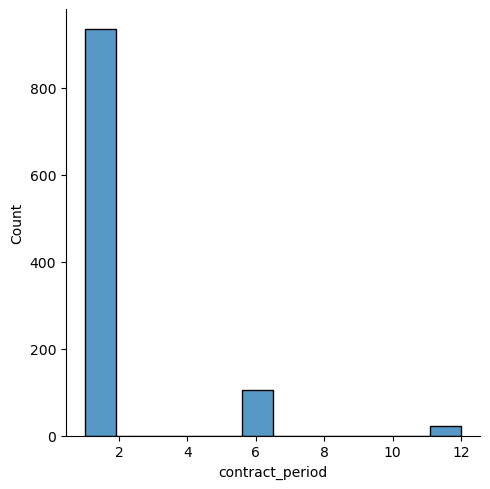

In [48]:
sns.displot(gym_churn_users['contract_period'])

Длительность текущего абонемента в большиснвте составляет около месяца.

Теперь построим график срока окончания абонемента.

In [49]:
sns.displot(gym_churn_users['month_to_end_contract'])

До окончания текущего действующего абонемента также составляет в районе одного месяца.

Проверим распределение по факту распределения групповых занятий.

In [18]:
# подсчитываем количество клиентов с групповыми занятиями
counts_group = gym_churn_users['group_visits'].value_counts()

# даем названия
labels = counts_group.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_group, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по посещению групповых занятий')
plt.show()

Все-таки большинство не посещает групповые занятия. Всего 26,9% предпочитает заниматься в группе.

Посмотрим на распределение средней частоты посещений в неделю.

In [50]:
sns.displot(gym_churn_users['avg_class_frequency_total'])

Чаще всего люди ходят 1-2 раза в неделю.

Посмотрим распределение средней частоты посещений в неделю за предыдущий месяц.

In [51]:
sns.displot(gym_churn_users['avg_class_frequency_current_month'])

За предыдущий месяц в равной степени клиенты посещали фитнес-центр 0 или 1 раз.

Посмотрим на распределение суммарной выручки.

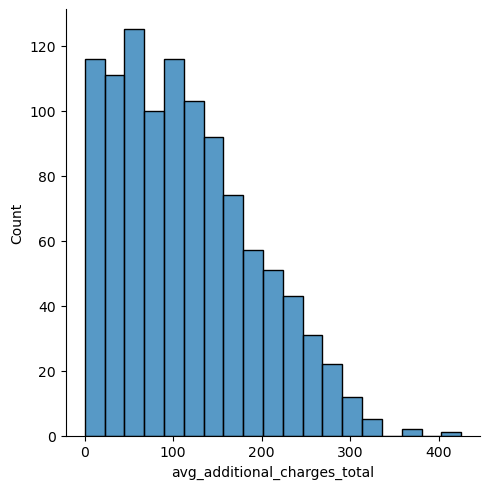

In [52]:
sns.displot(gym_churn_users['avg_additional_charges_total'])

Видим, что пиковые значения выручки находятся в районе 90.

**А теперь посмотрим на распределение пользователей, не попавших в отток.**

Посмотрим на распределние пользователей по полу. 

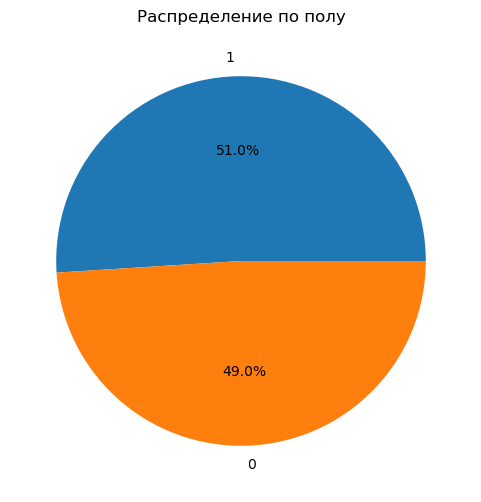

In [22]:
# подсчитываем количество мужчин и женщин
counts_gender = gym_users['gender'].value_counts()

# даем названия
labels = counts_gender.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_gender, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по полу')
plt.show()

Также видим, что распределение практически равное.

Построим диаграмму распределения живущих или работающих в районе фитнес-центра.

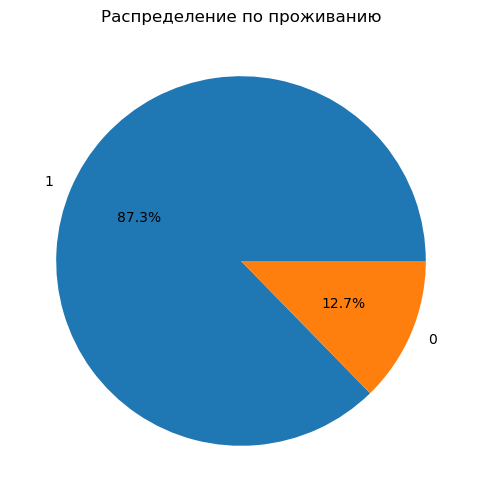

In [23]:
# подсчитываем количество проживающих рядом и нет
counts_near = gym_users['near_location'].value_counts()

# даем названия
labels = counts_near.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_near, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по проживанию')
plt.show()

Видим, что большинство (87,3%) проживает или работает в том же районе, где и находится фитнес-центр. Это неудивительно. Расстояние до дома/работы чаще всего является важным критерием при выборе тренажерного зала.

Построим распределение по сотрудникам компании-партнёра клуба.

In [24]:
# подсчитываем количество сотрудников компании-партнера клуба
counts_partner = gym_users['partner'].value_counts()

# даем названия
labels = counts_partner.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_partner, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по сотрудничеству')
plt.show()

Как видим на графике, большинство клиентов являются сотрудниками компании - 53,4%. Интересно, что в группе оттока, большинство клиентов не являются сотрудниками.

Теперь посмотрим на распределение по использованию промокода.

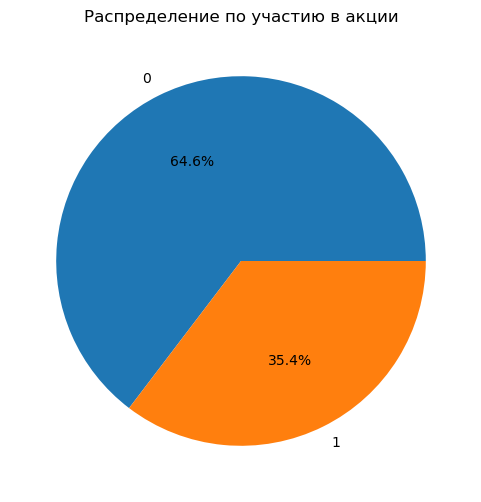

In [25]:
# подсчитываем количество клиентов, использовавших промокод
counts_promo = gym_users['promo_friends'].value_counts()

# даем названия
labels = counts_promo.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_promo, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по участию в акции')
plt.show()

Оказалось, что большинство клиентов - 64,6% не участвовали в промоакции. 

Проверим распределение по наличию контактного телефона.

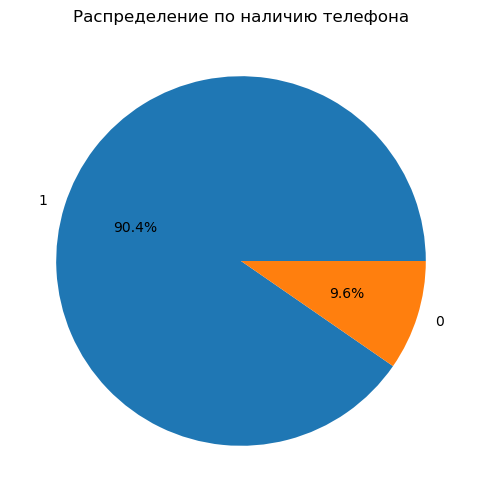

In [26]:
# подсчитываем количество клиентов с наличием контактного телефона
counts_phone = gym_users['phone'].value_counts()

# даем названия
labels = counts_phone.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_phone, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по наличию телефона')
plt.show()

Практически все клиенты оставили данных о наличие контактного телефона - 90,4%.

Построим график распределения по возрасту.

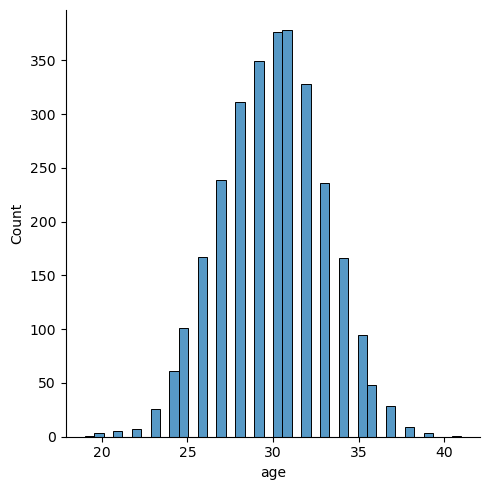

In [53]:
sns.displot(gym_users['age'])

Как видим, больше всего людей в возрасте 30 лет.

Посмотрим распределение по времени обращению в фитнес-центр.

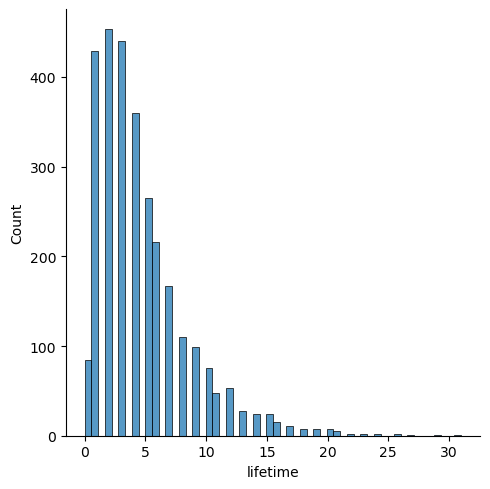

In [54]:
sns.displot(gym_users['lifetime'])

Как видим на графике, время обращения в фитнес-центр составляет около 3 месяцев. Намного больше, чем в группе оттока.

Посмотрим на длительность текущего абонемента в клиентов, которые ушли в отток.

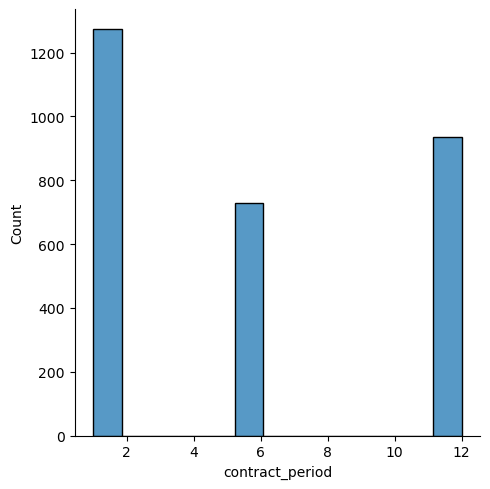

In [55]:
sns.displot(gym_users['contract_period'])

Длительность текущего абонемента рсапределяется в районе 1 месяца, 6 месяцев и 11 месяцев.

Теперь построим график срока окончания абонемента.

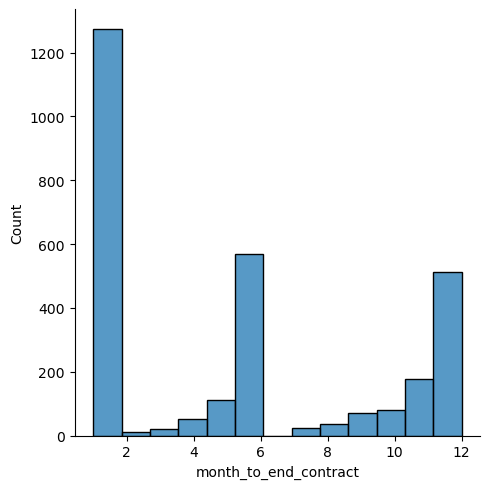

In [56]:
sns.displot(gym_users['month_to_end_contract'])

Здесь распределение тоже имеет скачки в районе 1 месяца, 6 и 11-12 месяцев.

Проверим распределение по факту распределения групповых занятий.

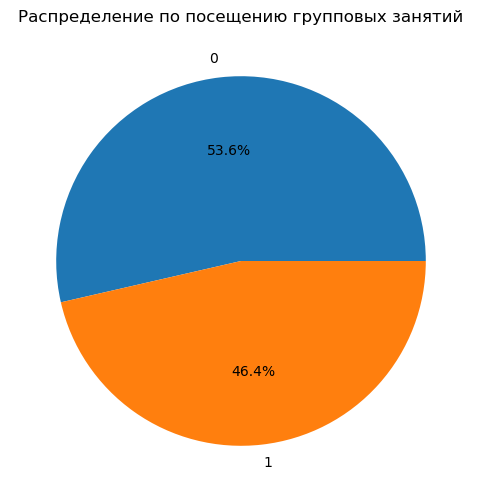

In [31]:
# подсчитываем количество клиентов с групповыми занятиями
counts_group = gym_users['group_visits'].value_counts()

# даем названия
labels = counts_group.index

# строим круговую диаграмму
plt.figure(figsize=(6, 6))
plt.pie(counts_group, labels=labels, autopct='%1.1f%%')
plt.title('Распределение по посещению групповых занятий')
plt.show()

Видим, что в этой группе больше людей ходит на групповые занятия, однако все равно преобладающее большинство (53,6%) предпочитают индивидуальные посещения.

Посмотрим на распределение средней частоты посещений в неделю.

In [57]:
sns.displot(gym_users['avg_class_frequency_total'])

Здесь люди ходят намного чаще, 2-3 раза в неделю.

Посмотрим распределение средней частоты посещений в неделю за предыдущий месяц.

In [58]:
sns.displot(gym_users['avg_class_frequency_current_month'])

И здесь видим увеличение - 2-3 раза в недел пользователи ходили в фитнес-центр за прошлый месяц.

Посмотрим на распределение суммарной выручки.

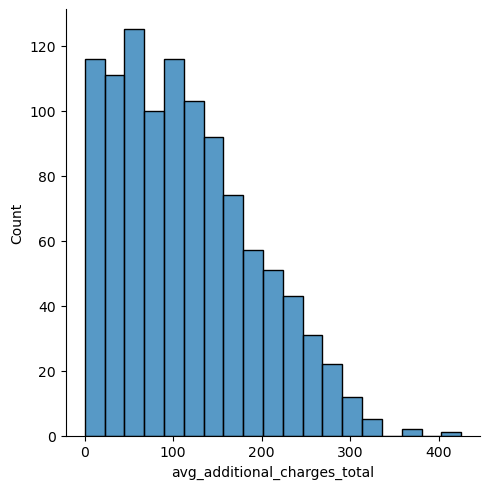

In [59]:
sns.displot(gym_churn_users['avg_additional_charges_total'])

А график суммарной выручки практически идентичен графику клиентов из прошлой группы.

**Построим матрицу корреляций и отобразим её.**

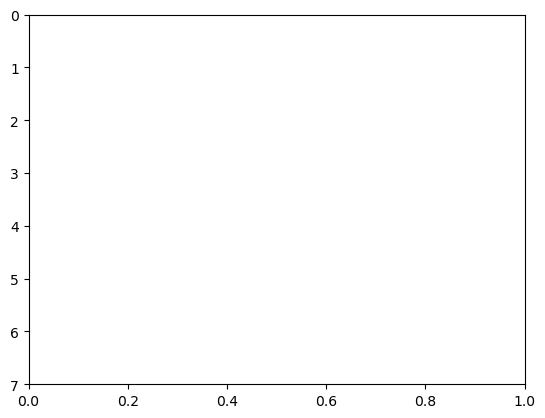

In [60]:
# построим и отрисуем матрицу корреляций
corr = gym_churn.corr()
fig, ax = plt.subplots()

# нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(10, 6)) 
sns.heatmap(corr, annot=True, fmt='.2g')
ax.set_ylim(
    7, 0
)  
# корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()

Видим, что достаточно плотное распределение. Большую концентрацию видим в столбце длительности текущего периода.

**Выводы:** ознакомились с данными, изучили средние значения и стандартные отклонения, сравнили значения групп пользователей, ушедших с оттоком и тех, кто остался, построили и отобразили матрицу корреляций. 
Отличия лояльных клиентов от оттоковых:

1. Большее количество лояльных клиентов живут рядом с центром
2. 65% оттоковых клиентов не являются сотрудниками компании.
3.  На 20% больше оттоковые клиенты не участвовали в промоакции.
4. Уходят чаще молодые люли в возрасте 25-27 лет, люди в 30 лет чаще остаются.
5. Длительность уходящих клиентов составляет около месяца, в то время как у лояльных варьируется в районе 1-го,6-ти и 11-ти месяцев. Стоит подумать, что предложить уходящим клиентам в последний месяц пользования.
6. Оттоковые пользователи реже посещают групповые занятия (где-то на 20%).
7. Реже на тренировки ходят оттоковые клиенты, 1-2 раза. Лояльные занимаются 2-3 раза.
8. Также видим данные за прошлый месяц: большинство уходящих ходили максимум 1 раз. Дополнительная мотивация здесь не помешала бы.

## Шаг 3. Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. 

In [36]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

In [37]:
# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Обучим модель логистической регрессией. 

In [38]:
# зададим алгоритм для нашей модели
model = LogisticRegression(random_state=0)

Accuracy: 0.92
Precision: 0.86
Recall: 0.83
F1-score: 0.84
ROC-AUC: 0.97

Confusion Matrix:
[[575  27]
 [ 34 164]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       602
           1       0.86      0.83      0.84       198

    accuracy                           0.92       800
   macro avg       0.90      0.89      0.90       800
weighted avg       0.92      0.92      0.92       800



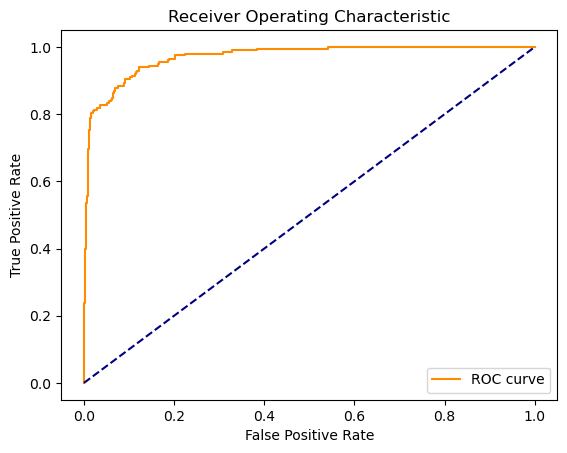

In [63]:
# Увеличим max_iter для решения проблемы сходимости
model = LogisticRegression(max_iter=1000)  # или другое значение, например 2000
model.fit(X_train, y_train)

# Делаем прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

# Выводим метрики
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')
print(f'Precision: {precision_score(y_test, predictions):.2f}')
print(f'Recall: {recall_score(y_test, predictions):.2f}')
print(f'F1-score: {f1_score(y_test, predictions):.2f}')
print(f'ROC-AUC: {roc_auc_score(y_test, probabilities):.2f}')

# Матрица ошибок
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

# Отчет классификации
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Дополнительно: ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Процент точности достаточно высок - 92%, доля верных прогнозов составляет 82% и recall составляет 83. Посмотрим, какие результаты будут у случайного леса.

А теперь случайным лесом.

In [40]:
# зададим алгоритм на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train, y_train) 

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# выведем все изученные метрики для полученного прогноза
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')
print(f'Precision: {precision_score(y_test, predictions):.2f}')
print(f'Recall: {recall_score(y_test, predictions):.2f}')

Accuracy: 0.92
Precision: 0.87
Recall: 0.81


Здесь точность составляет 92, метрики precision и recall также стремятся к единице, но все равно они все выше, чем в прошлом способе.

Можем сделать вывод, что второй способ (случайный лес) показал лучшие результаты.

## Шаг 4. Сделаем кластеризацию клиентов

Проведем кластеризацию клиентов. Рассмотрим тех, кто не попал в отток.

In [41]:
# стандартизируем данные и построим матрицу расстояний
sc = StandardScaler()
X_sc = sc.fit_transform(gym_churn)

linked = linkage(X_sc, method = 'ward') 

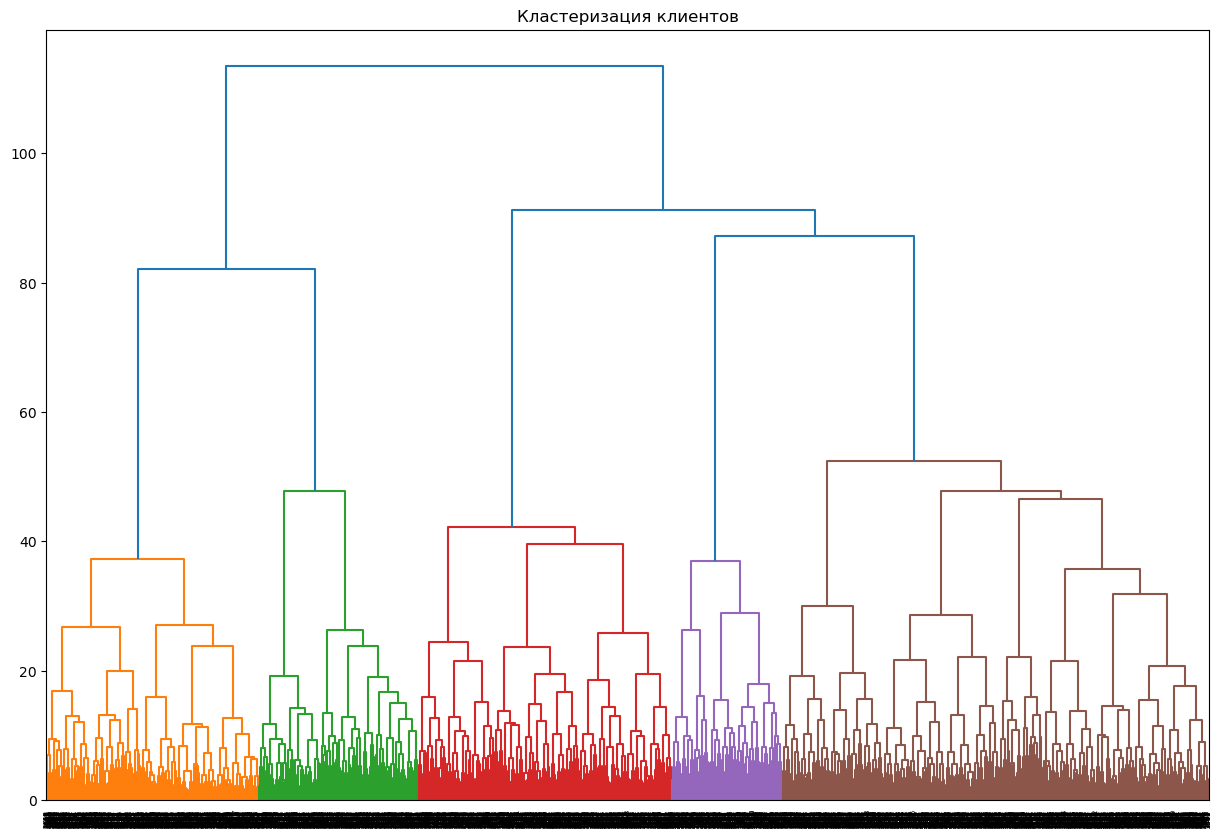

In [42]:
# нарисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show()

Предложенное актуальное число кластеров - 5.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [65]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

In [44]:
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster'] = labels
gym_churn.head()

gender  near_location  partner  promo_friends  phone  contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   group_visits  age  avg_additional_charges_total  month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   lifetime  avg_class_frequency_total  avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   churn  cluster  
0      0        4  
1      0        3  
2      0        0  
3      0        3  
4      0        0

In [45]:
# выводим статистику по средним значениям наших признаков по кластеру
display(gym_churn.groupby('cluster').mean())

gender  near_location   partner  promo_friends     phone  \
cluster                                                               
0        0.475694       0.825231  0.446759       0.252315  1.000000   
1        0.549645       0.842790  0.374704       0.216312  0.998818   
2        0.507447       0.760638  0.341489       0.179787  0.997872   
3        0.503619       0.938987  0.768356       0.564633  1.000000   
4        0.524804       0.866841  0.469974       0.308094  0.000000   

         contract_period  group_visits        age  \
cluster                                             
0               2.643519      0.380787  30.021991   
1               2.750591      0.442080  29.977541   
2               1.567021      0.257447  26.908511   
3              11.168563      0.558428  29.895553   
4               4.806789      0.428198  29.331593   

         avg_additional_charges_total  month_to_end_contract  lifetime  \
cluster                                                                  
0                          153.404553               2.461806  4.671296   
1                          160.245842               2.528369  4.593381   
2                          115.109065               1.513830  0.976596   
3                          161.582993              10.218201  4.703206   
4                          144.156967               4.493473  3.945170   

         avg_class_frequency_total  avg_class_frequency_current_month  \
cluster                                                                 
0                         1.184034                           1.183023   
1                         2.933126                           2.939963   
2                         1.448700                           1.026250   
3                         2.005548                           1.999999   
4                         1.855107                           1.723740   

            churn  
cluster            
0        0.001157  
1        0.007092  
2        0.997872  
3        0.015512  
4        0.263708

Судя по средним значениям, разделенные по кластерам можем сделать следующие выводы: средний возраст колеблется в районе 28-30 лет, время с момента первого обращния в фитнес-центр не превышает 4 месяца, длительность текущего действующего абонемента и срок до окончания текущего абонемента достаточно разбросаны по времени, средняя частота посещений - 1-2 раза. суммарная выручка составляет 1- 2. 

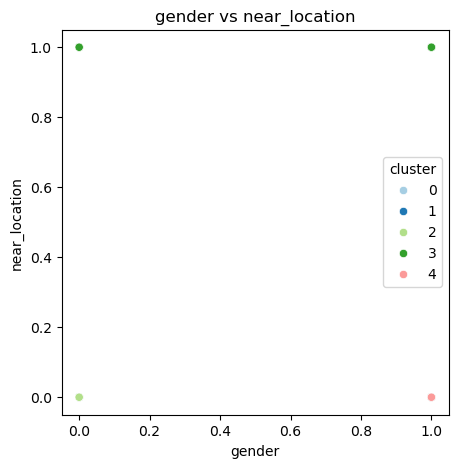

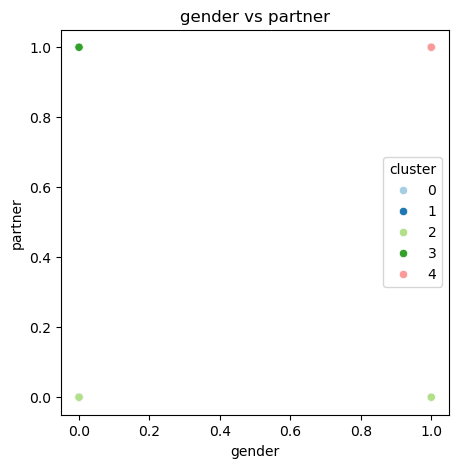

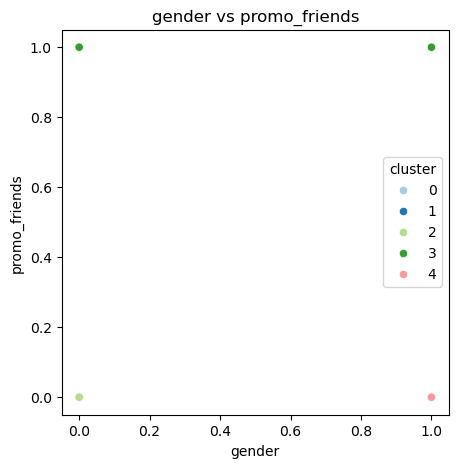

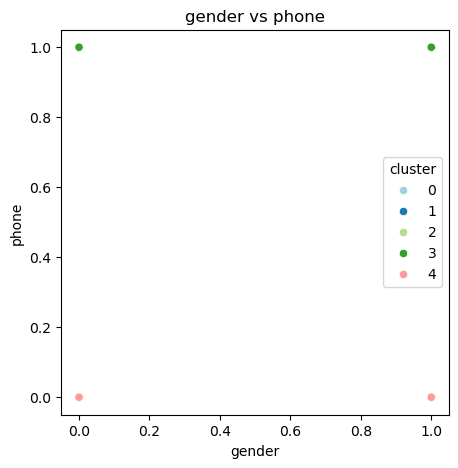

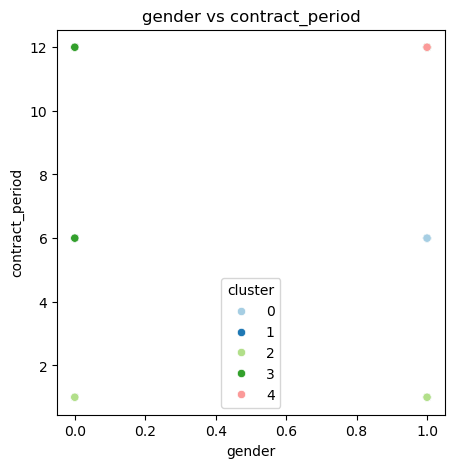

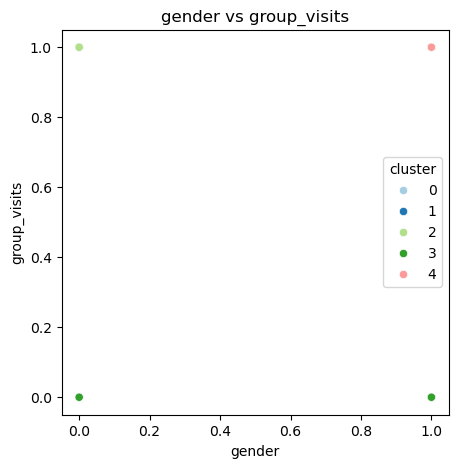

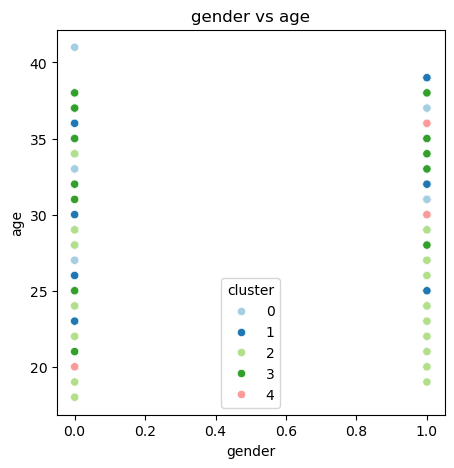

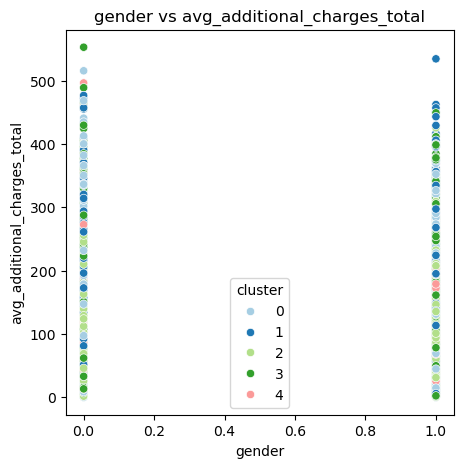

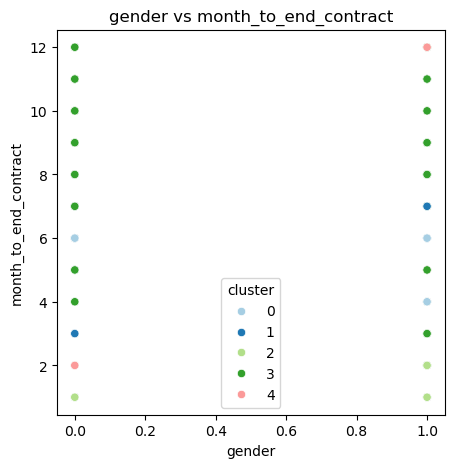

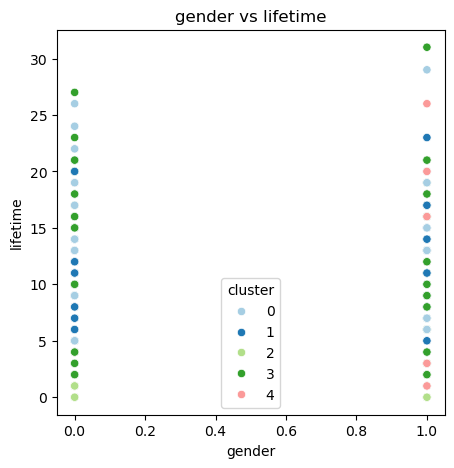

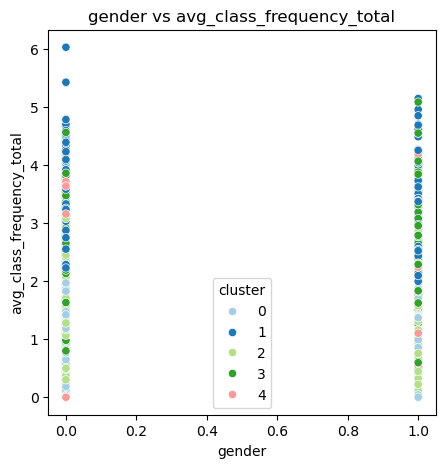

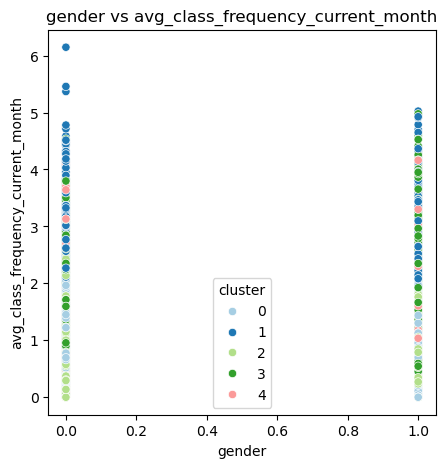

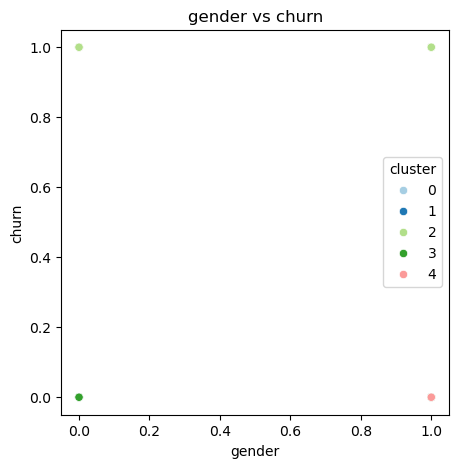

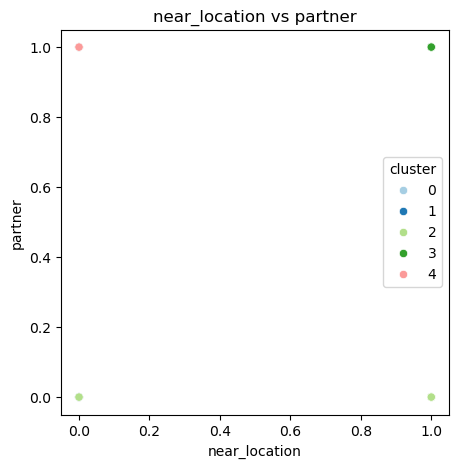

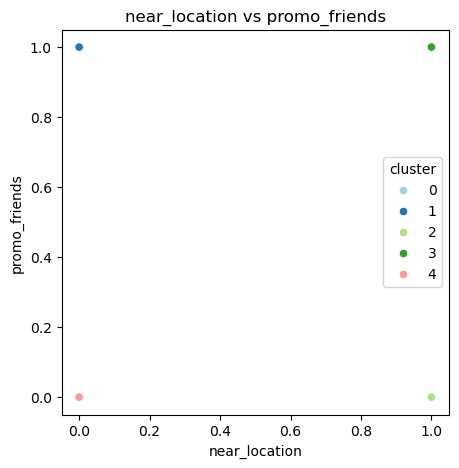

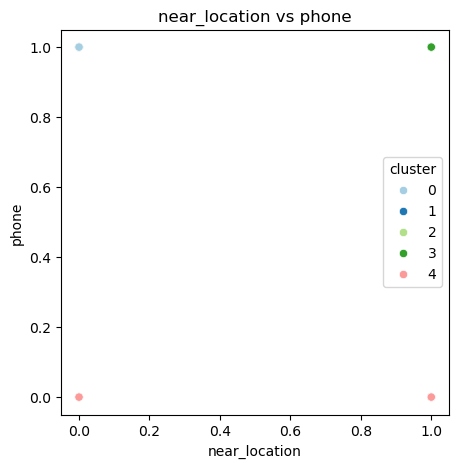

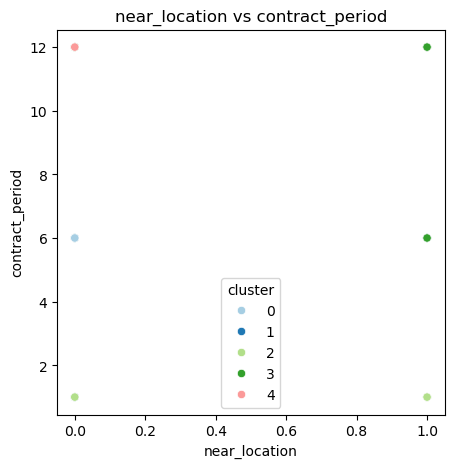

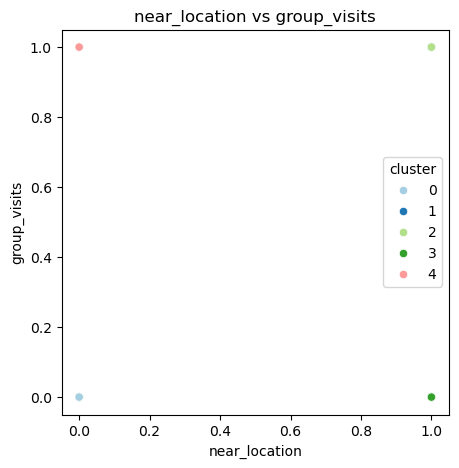

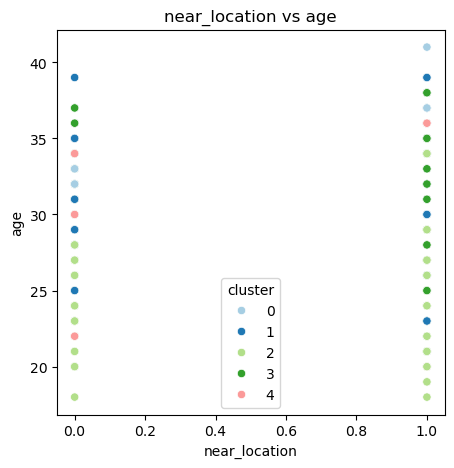

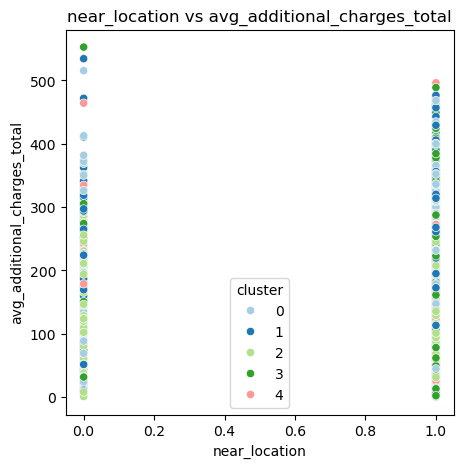

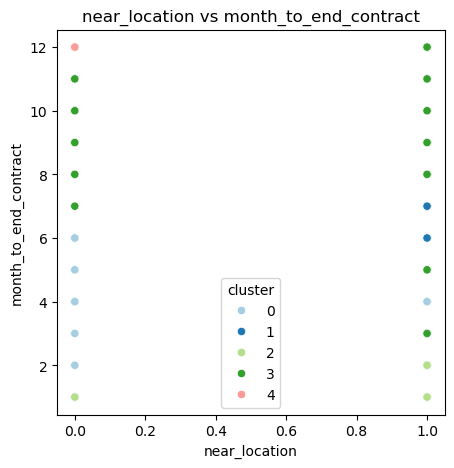

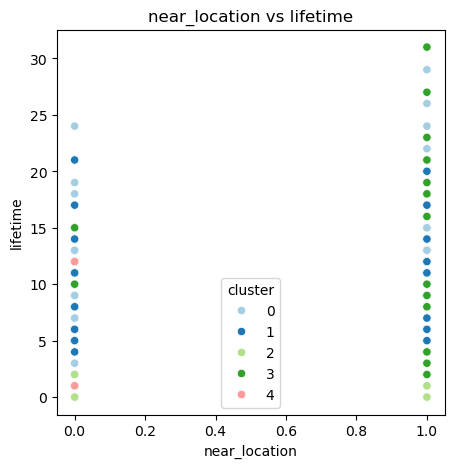

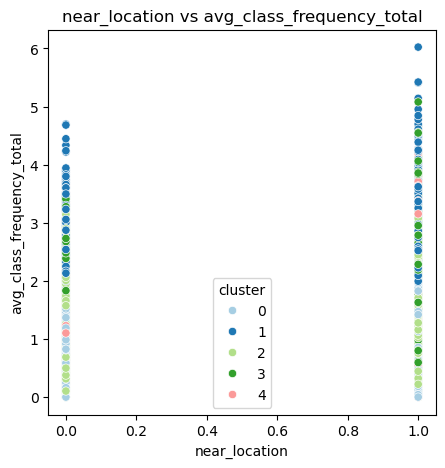

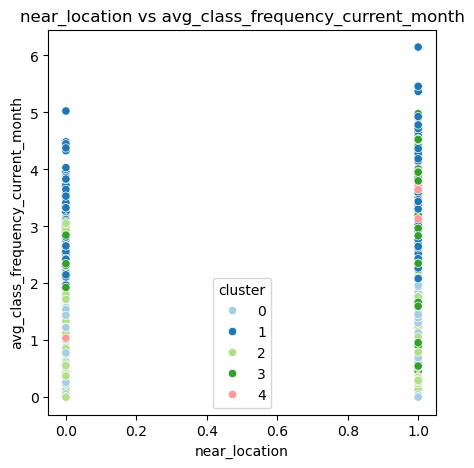

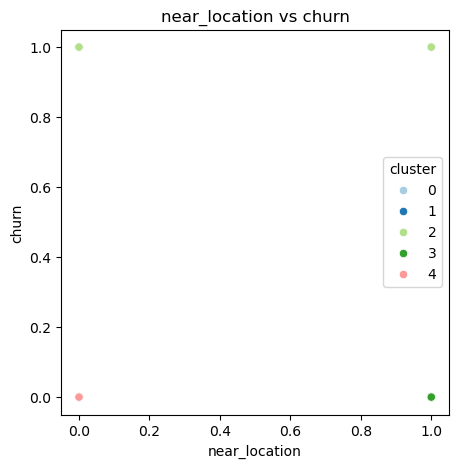

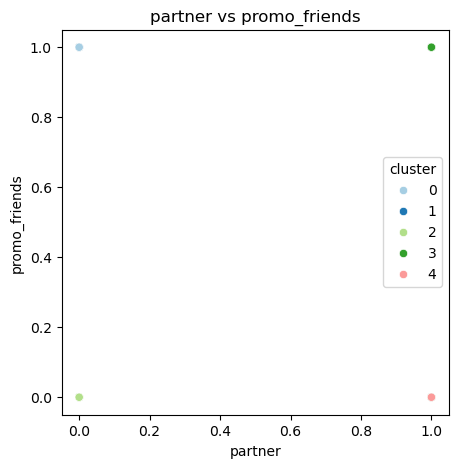

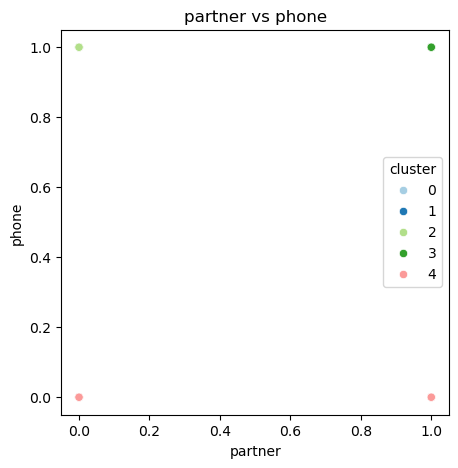

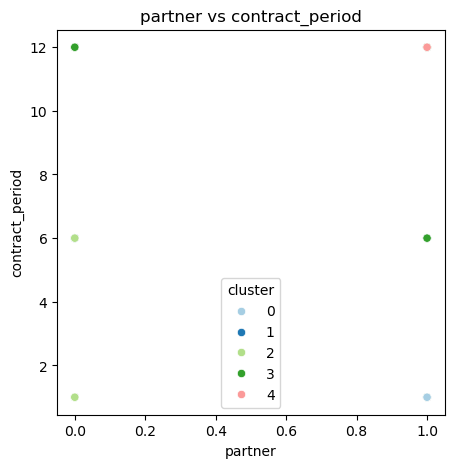

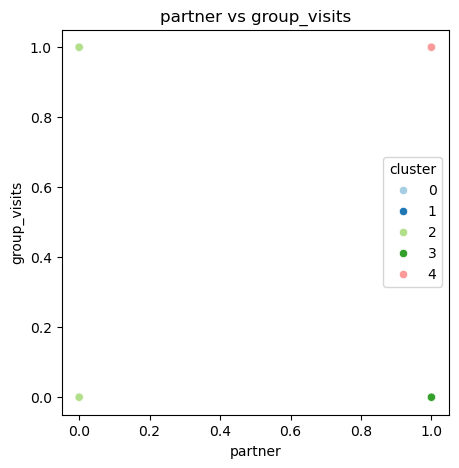

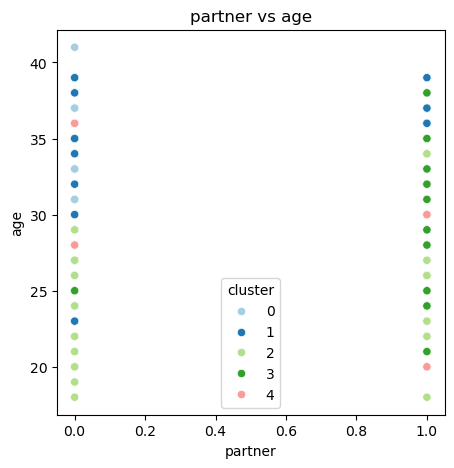

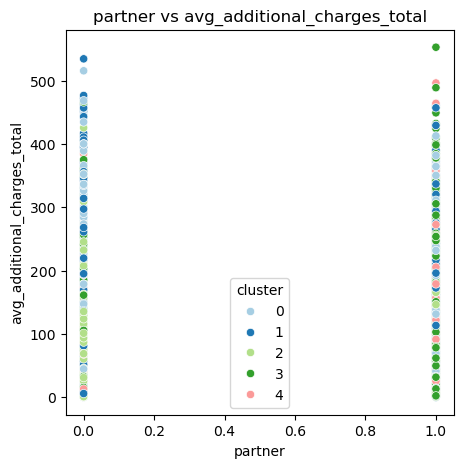

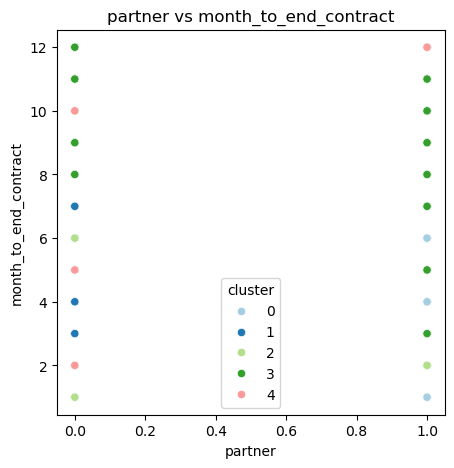

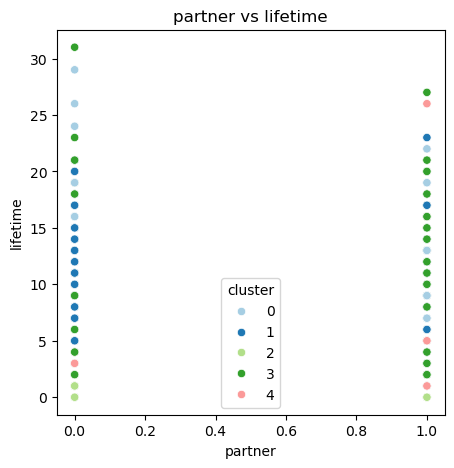

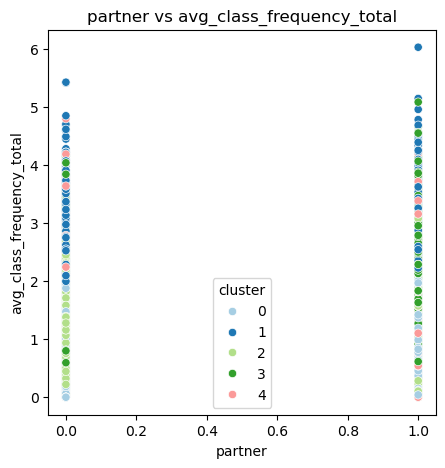

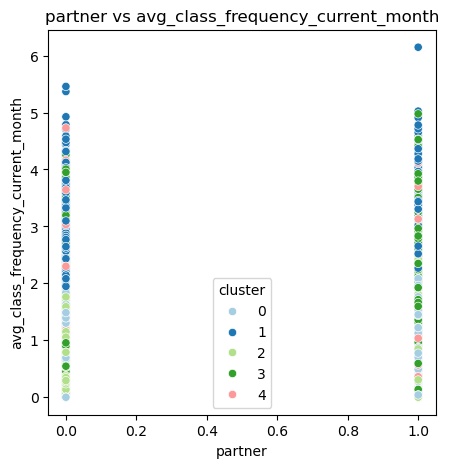

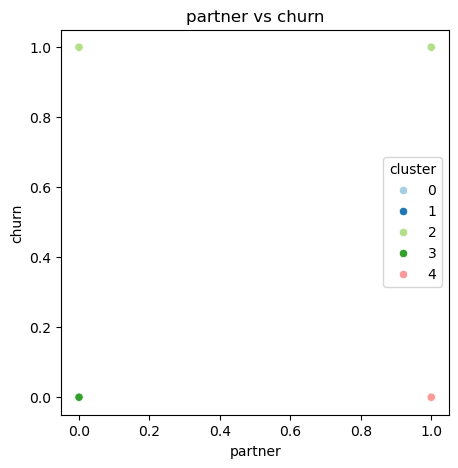

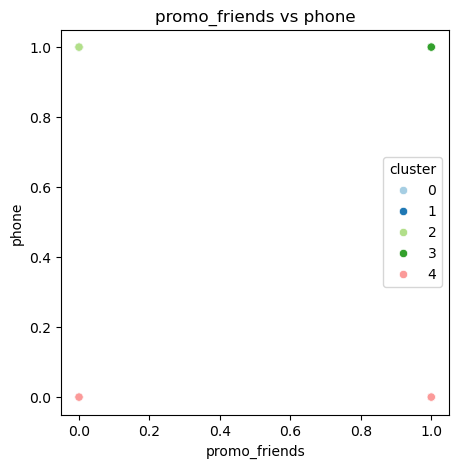

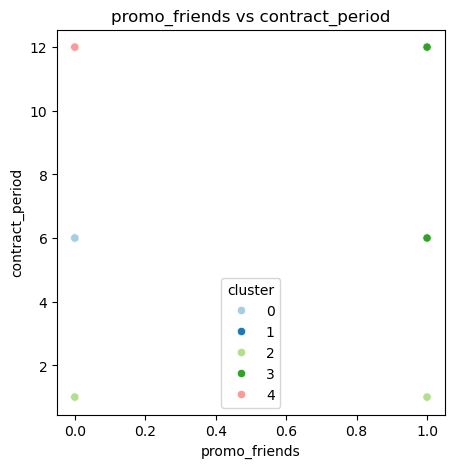

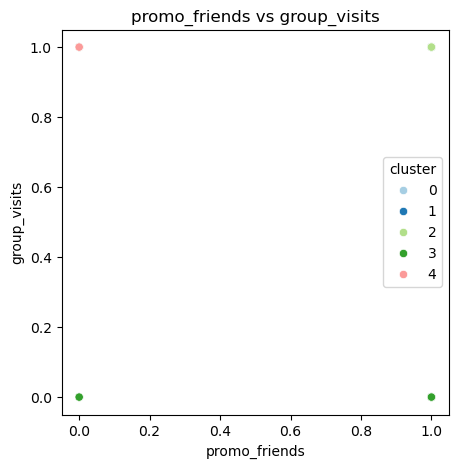

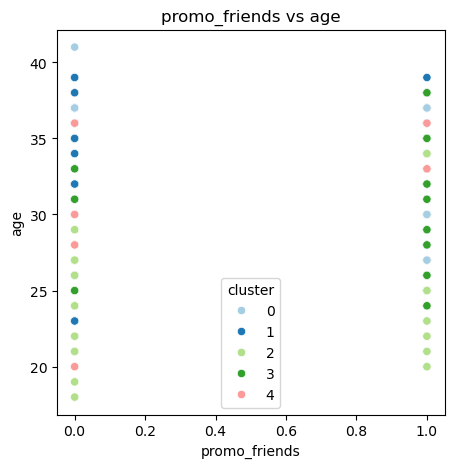

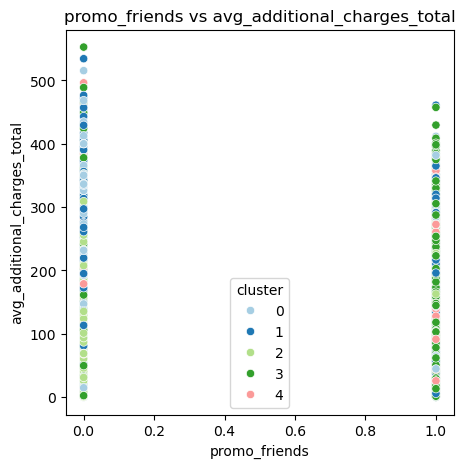

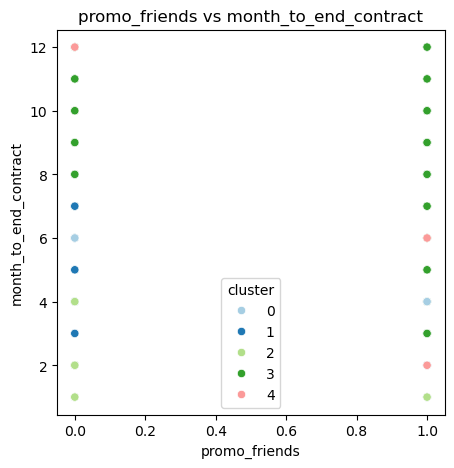

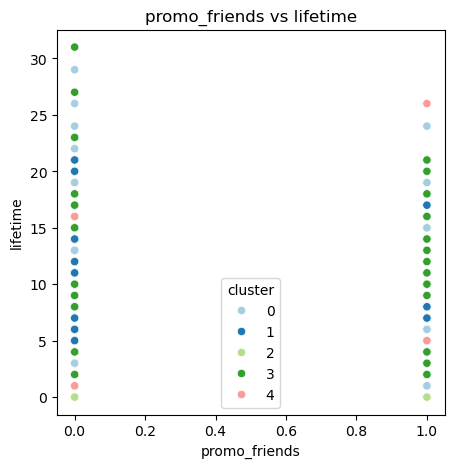

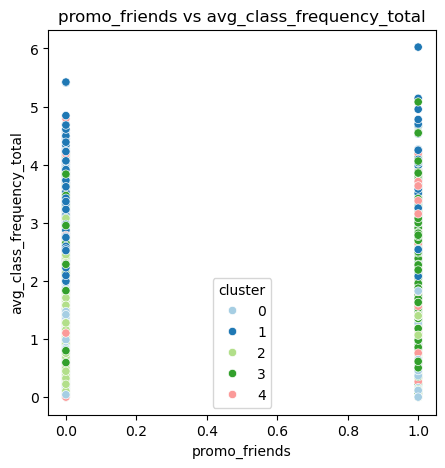

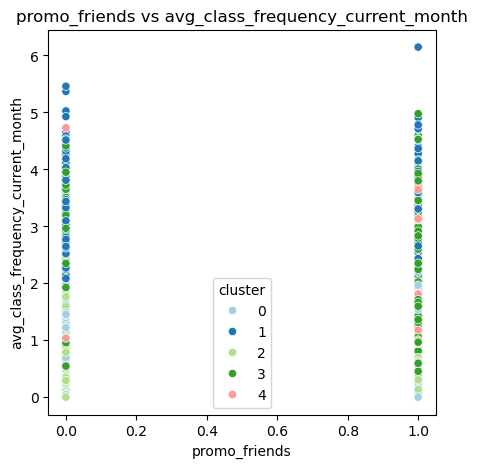

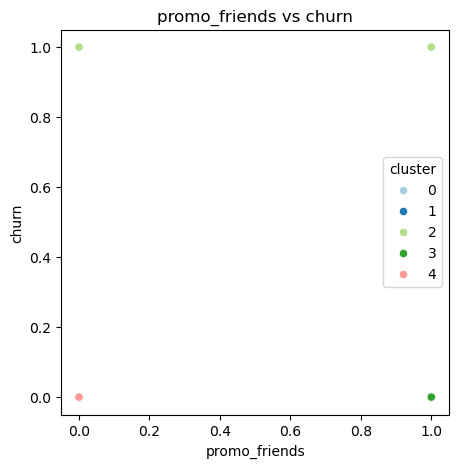

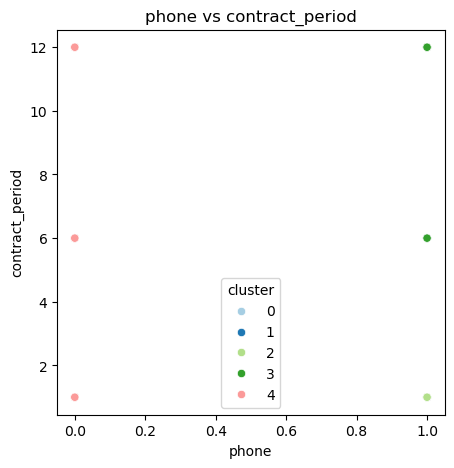

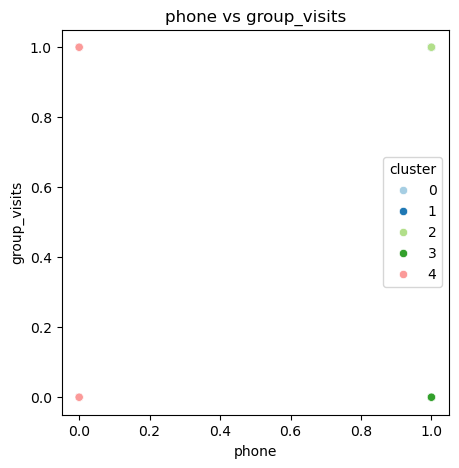

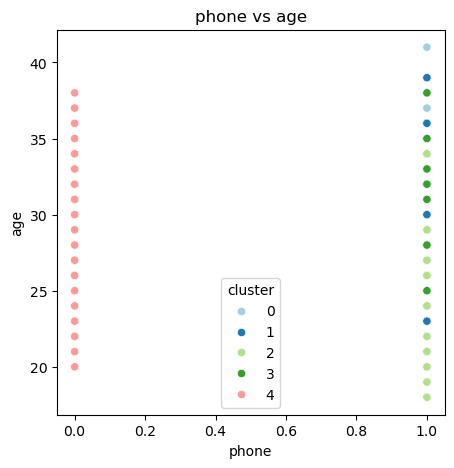

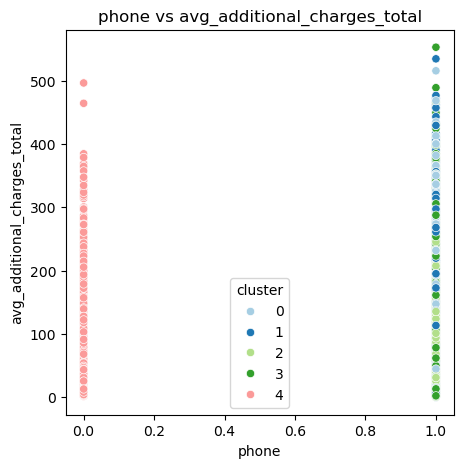

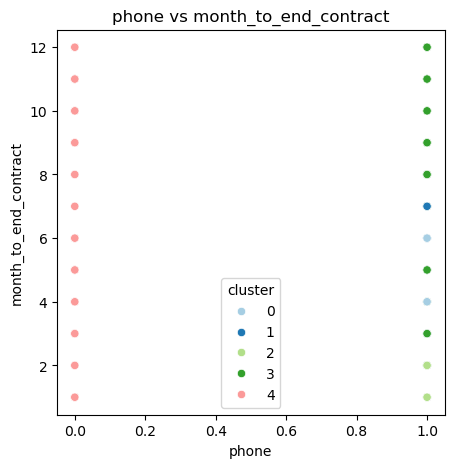

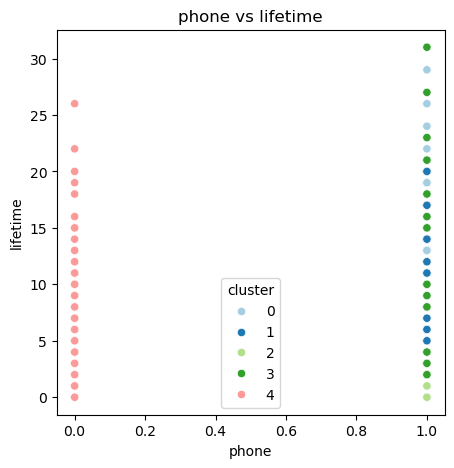

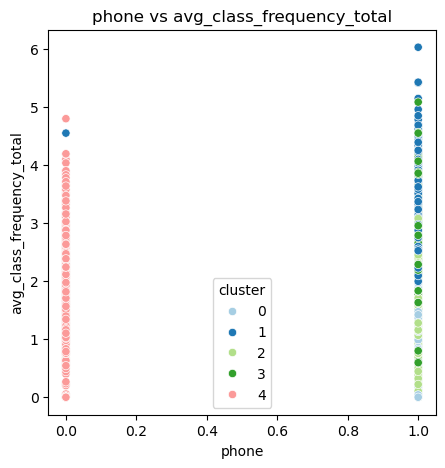

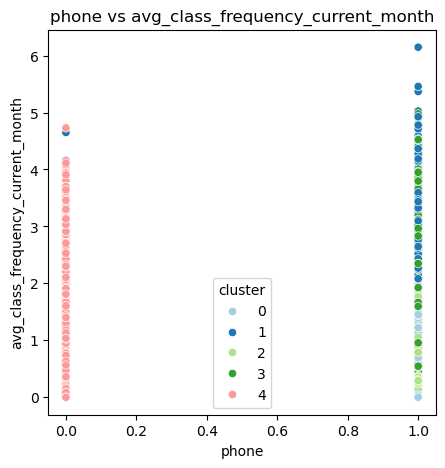

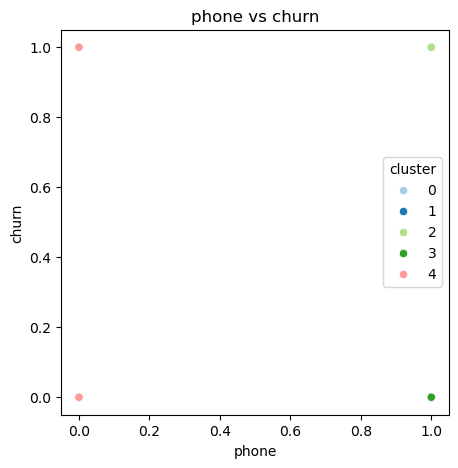

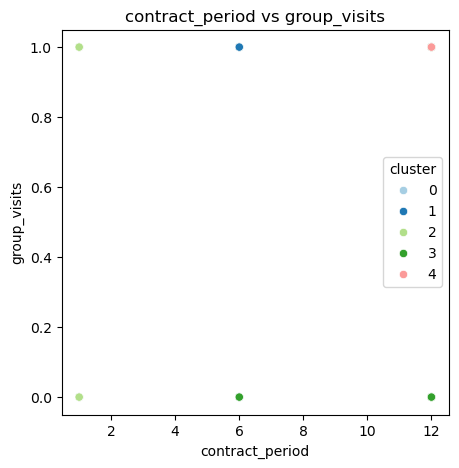

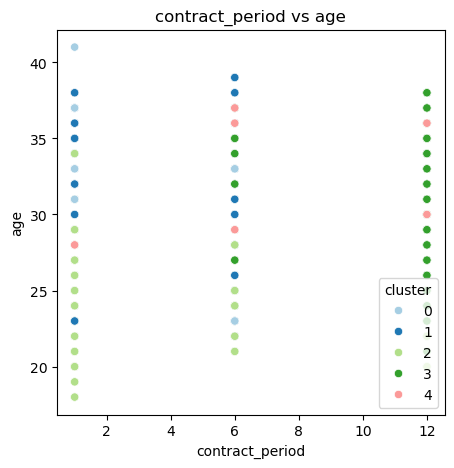

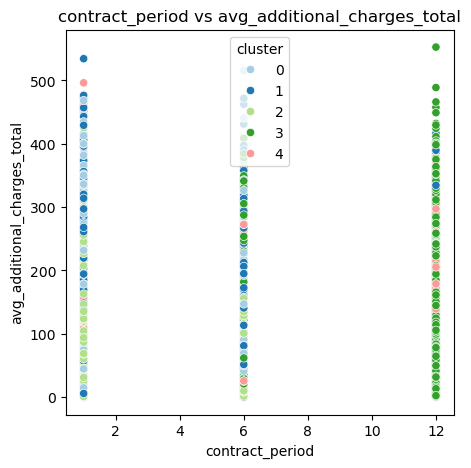

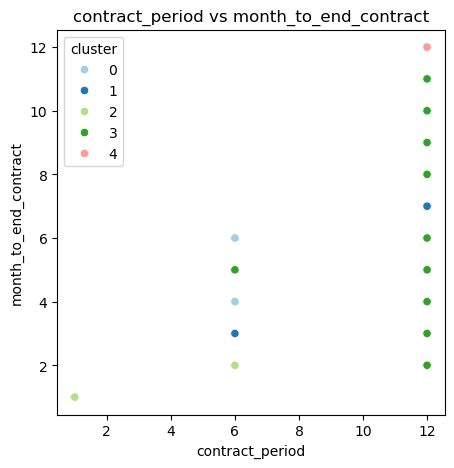

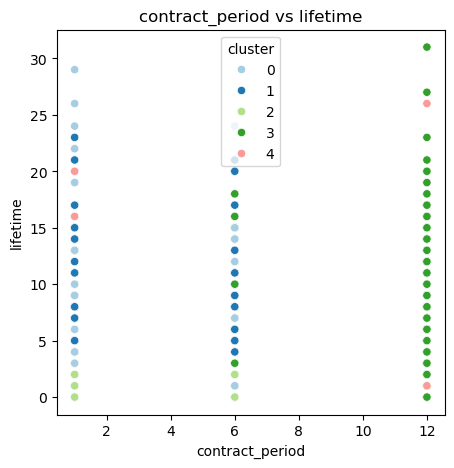

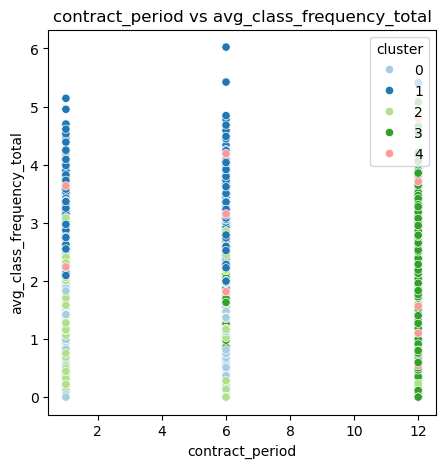

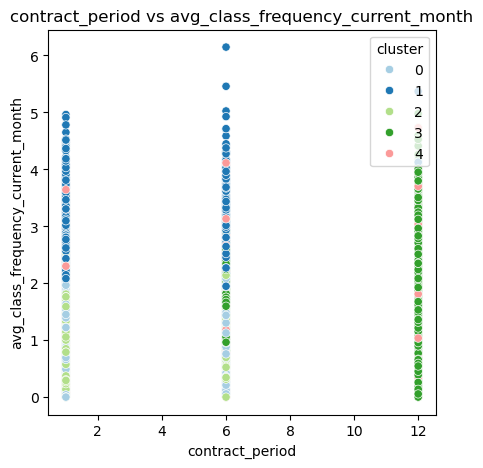

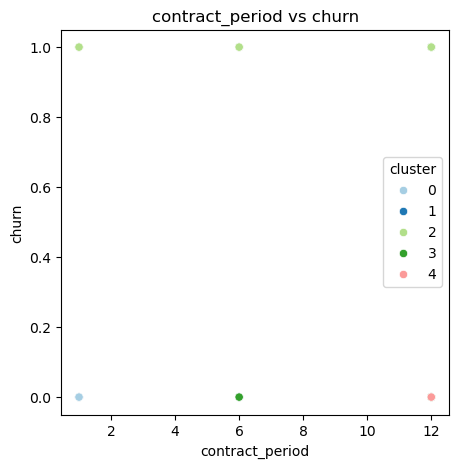

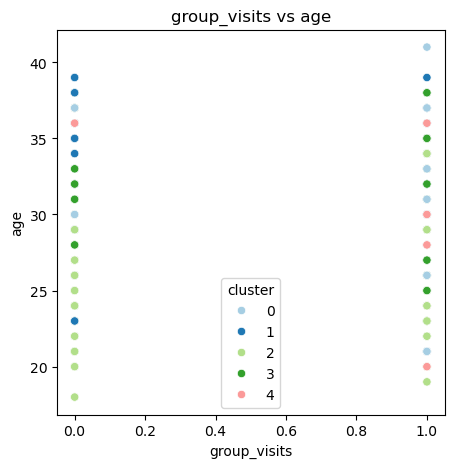

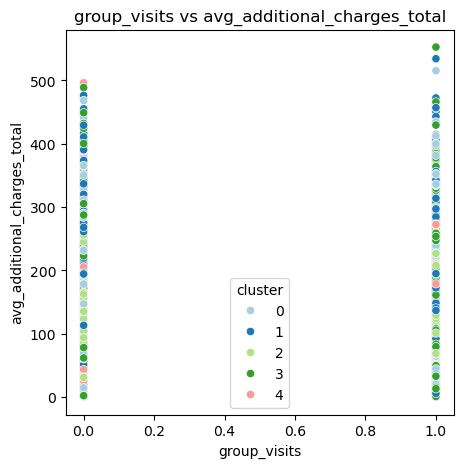

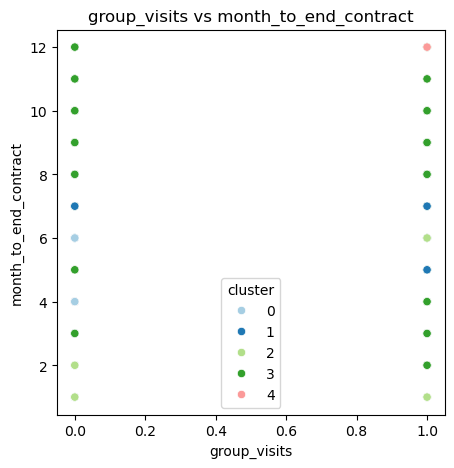

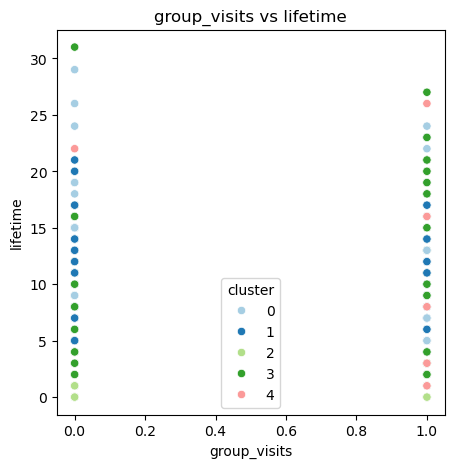

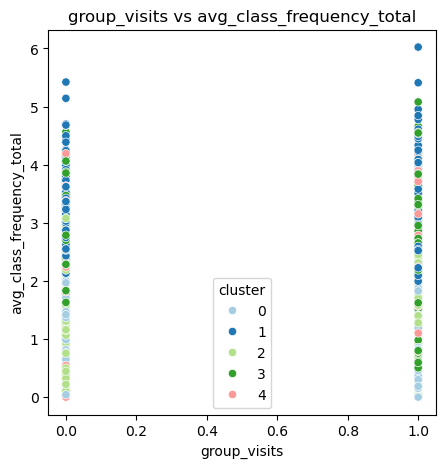

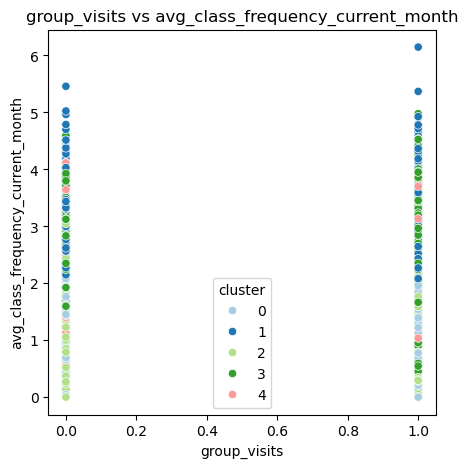

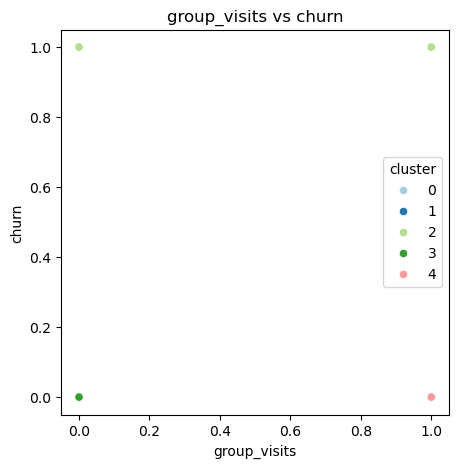

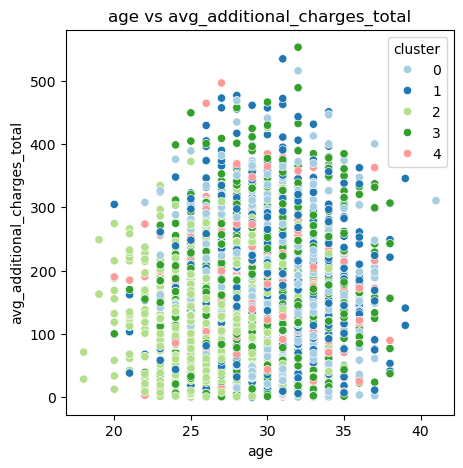

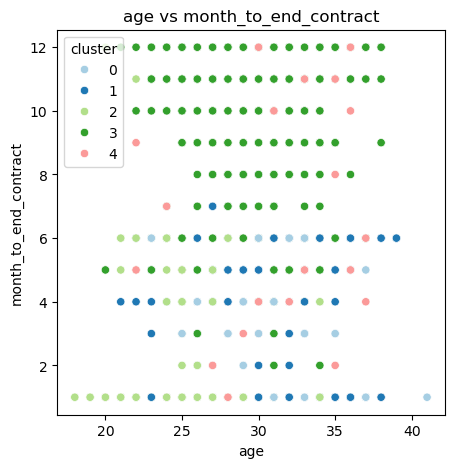

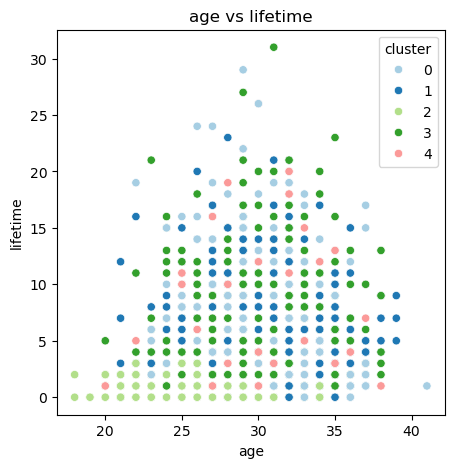

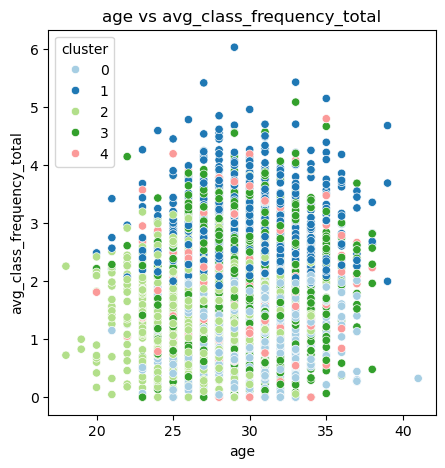

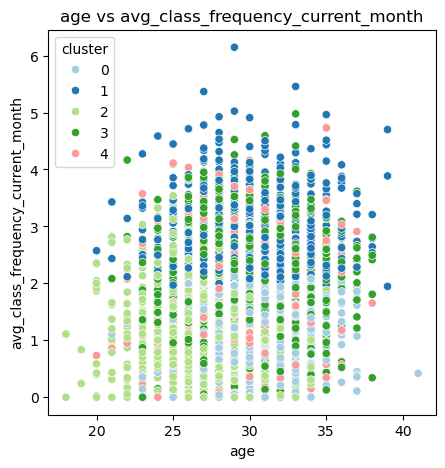

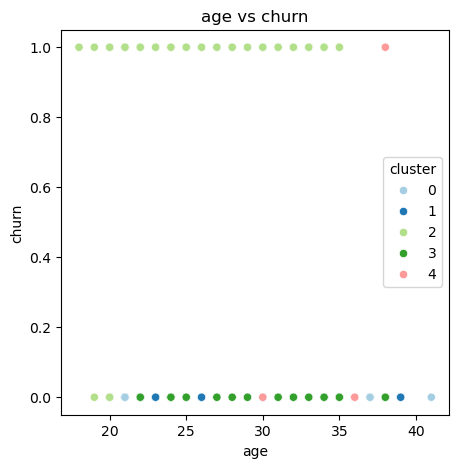

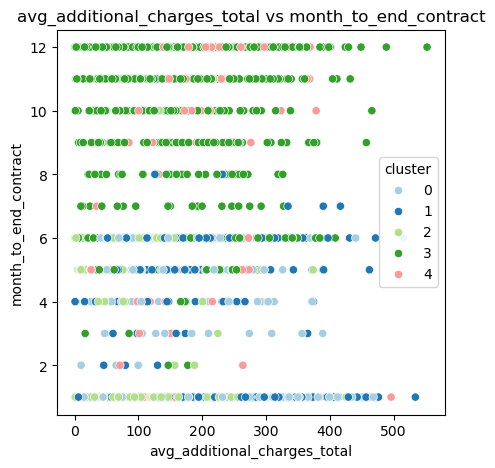

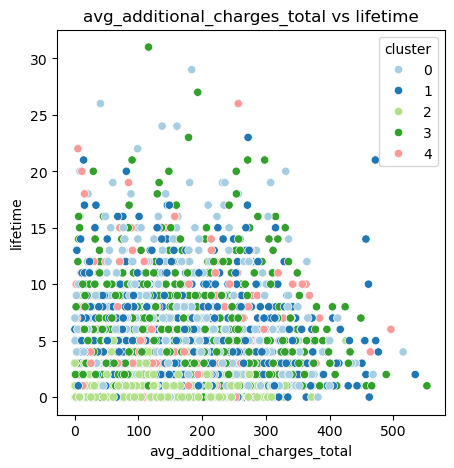

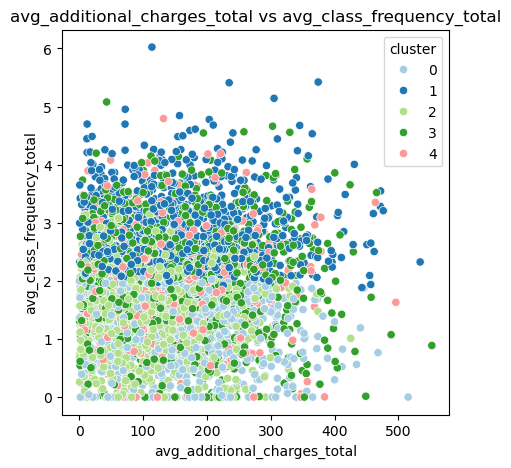

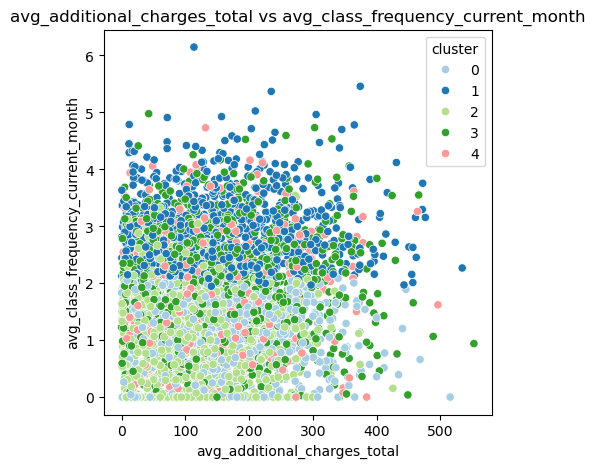

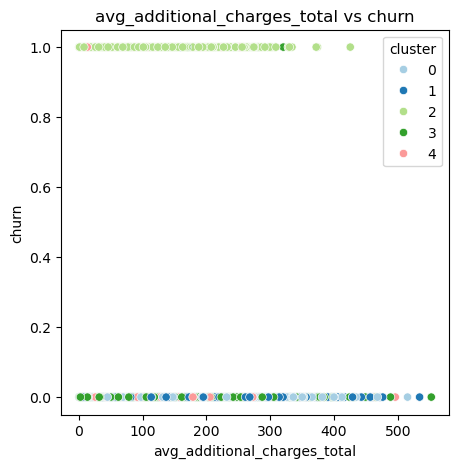

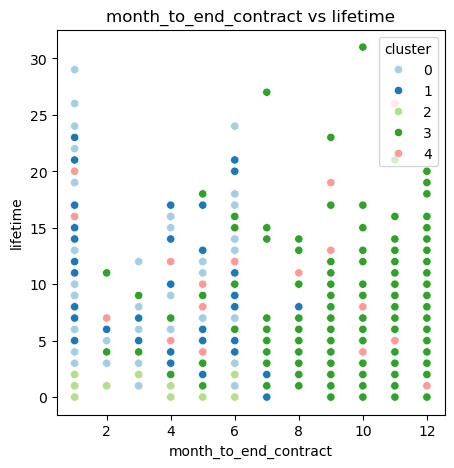

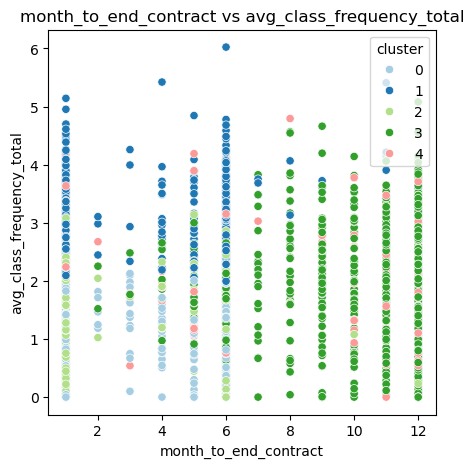

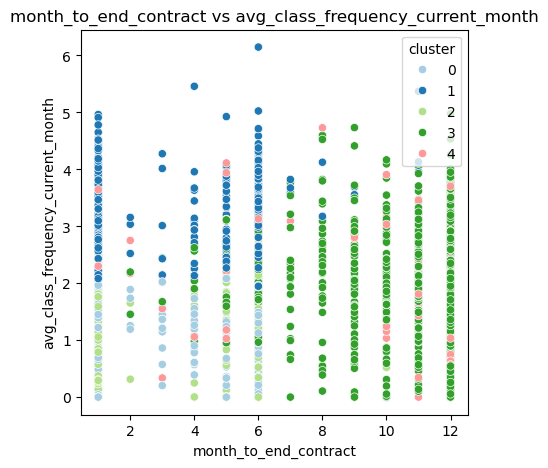

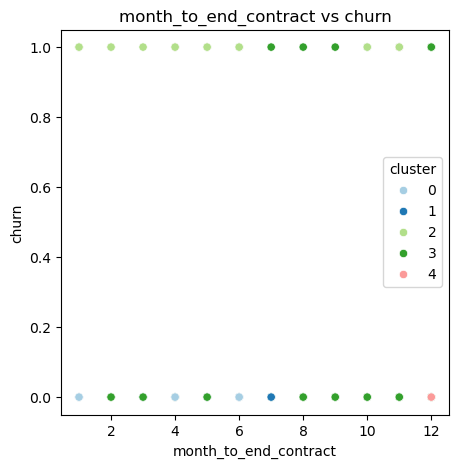

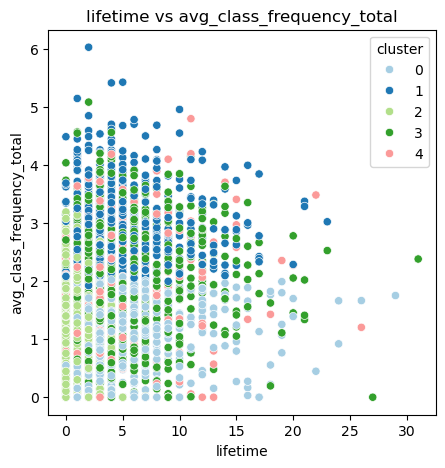

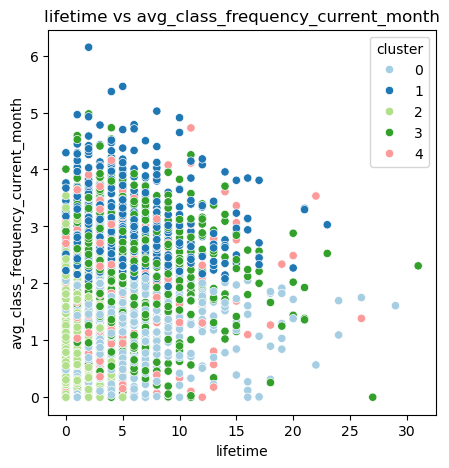

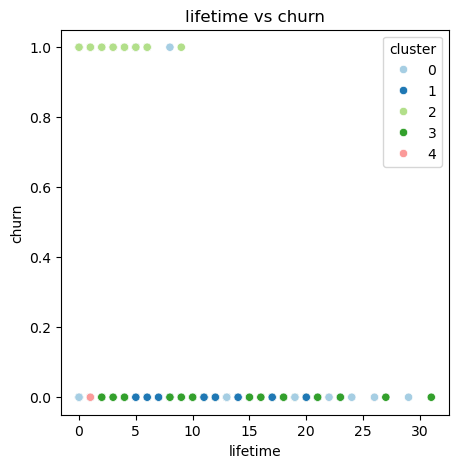

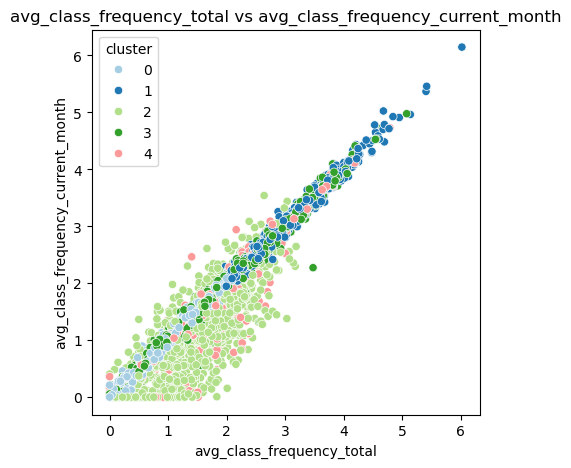

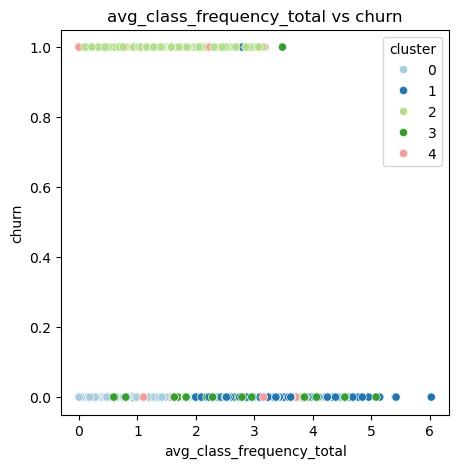

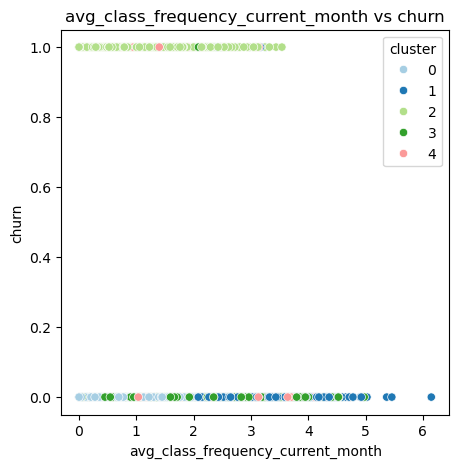

In [67]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        data=df,  # Добавлен параметр data
        x=x_name,  # Название столбца для оси X
        y=y_name,  # Название столбца для оси Y
        hue=cluster_name,  # Название столбца для цветов
        palette='Paired'
    )
    plt.title(f'{x_name} vs {y_name}')  # Использована f-строка
    plt.show()

# Генерация пар признаков
col_pairs = list(itertools.combinations(gym_churn.drop('cluster', axis=1).columns, 2))

# Построение графиков для каждой пары
for pair in col_pairs:
    show_clusters_on_plot(gym_churn, pair[0], pair[1], 'cluster')

Разделение по полу не сможем прокомментировать, так как не знаем обозначения 0 и 1 в распределении. 
Люди в возрасте 40+ не имеют абонемента дольше 1 месяца, группа 20+ - 40 лет пользуются 6-месячным абонементом.
Самая высокая суммарная выручка от других услуг фитнес-центра насчитывается у владельцев 12-месячного абонемента.
Самая частая группа по поещениям - люди с 6-месячным абонементом, также выше всего средняя частота посещений за предыдущий месяц.
Больше всего выручки от пользования лдругих услуг центра приносят люди в возрасте от 30 до 35 лет.
У людей 40+ самый короткий остаток абонемента, меньше 1 месяца.
Самое длительное время с моента обращения первый раз в фитнес-центр у людей в возрасте около 32 лет.
Чаще всего ходят в спортзал люди в возрасте 29-ти лет. У них же зарешистрированы самые частые посещения за предыдущий месяц.
После 35-лет уровень оттока падает.
Суммарная выручка больше у тех, кто ходит в зал не более 5 месяцев.
При увеличении частоты посещений в неделю растет сумма выручки, однако частота покупок сконцентрирована в районедо 4 посещений.
Чаще всего ходят те, у кого осталось 6 месяцев до окончания абонемента.
Чаще всего ходят "новички" - те, кто приобрел абонемент 3 месяца назад.
отток клиентов идет после 10 месяцев.

In [ ]:
# группируем данные по кластерам
grouped = gym_churn.groupby('cluster')

# вычисляем долю оттока для каждого кластера
churn_rate = grouped['churn'].mean()
churn_rate

Самые надежные кластеры - 1 и 3. Наиболее подвержен оттоку - 2.

## Шаг 5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

Мы проанализировали данные о посетителях фитнес-центра.  

Первоначальные краткие выводы такие:  
- время с момента первого обращения в фитнес-центр в среднем составляет 3-4 месяца
- срок до окончания действующего абонемента составляет около 4 месяцев
- среднее от среднего частоты посещений в неделю за все время с начала действия абонемента сотавляет 1-2
- среднее от средней частоты посещений в неделю за предыдущий месяц - 1-2
- суммарная выручка от других услуг центра примерно 147

Всех посетителей мы разделили по признаку оттока.
Отличия лояльных клиентов от оттоковых:

1. Большее количество лояльных клиентов живут рядом с центром
2. 65% оттоковых клиентов не являются сотрудниками компании.
3.  На 20% больше оттоковые клиенты не участвовали в промоакции.
4. Уходят чаще молодые люли в возрасте 25-27 лет, люди в 30 лет чаще остаются.
5. Длительность уходящих клиентов составляет около месяца, в то время как у лояльных варьируется в районе 1-го,6-ти и 11-ти месяцев. Стоит подумать, что предложить уходящим клиентам в последний месяц пользования.
6. Оттоковые пользователи реже посещают групповые занятия (где-то на 20%).
7. Реже на тренировки ходят оттоковые клиенты, 1-2 раза. Лояльные занимаются 2-3 раза.
8. Также видим данные за прошлый месяц: большинство уходящих ходили максимум 1 раз. Дополнительная мотивация здесь не помешала бы.

Далее мы построили модель прогнозирования оттока клиентов и выяснили, что способ распределния случайным лесом оказался аниболее приемлимым.

Применив кластеризацию, можем сказать, что: 
-  Люди в возрасте 40+ не имеют абонемента дольше 1 месяца, группа 20+ - 40 лет пользуются 6-месячным абонементом. 
- Самая высокая суммарная выручка от других услуг фитнес-центра насчитывается у владельцев 12-месячного абонемента. 
- Самая частая группа по поещениям - люди с 6-месячным абонементом, также выше всего средняя частота посещений за предыдущий месяц. 
- Больше всего выручки от пользования лдругих услуг центра приносят люди в возрасте от 30 до 35 лет. 
- У людей 40+ самый короткий остаток абонемента, меньше 1 месяца. 
- Самое длительное время с моента обращения первый раз в фитнес-центр у людей в возрасте около 32 лет. 
- Чаще всего ходят в спортзал люди в возрасте 29-ти лет. У них же зарегистрированы самые частые посещения за предыдущий месяц. - После 35-лет уровень оттока падает. 
- Суммарная выручка больше у тех, кто ходит в зал не более 5 месяцев. 
- При увеличении частоты посещений в неделю растет сумма выручки, однако частота покупок сконцентрирована в районедо 4 посещений. 
- Чаще всего ходят те, у кого осталось 6 месяцев до окончания абонемента. 
- Чаще всего ходят "новички" - те, кто приобрел абонемент 3 месяца назад. 
- Отток клиентов идет в первые 10 месяцев.

**Рекомендации для работы с клиентами:**

Для того, чтобы улучшить ситуацию фитнес-центра надо стремиться привлекать новых клиентов и удерживать старых. Для меньшинства стоит подумать над вовлекающими акциями или способами дополнительной лояльности. Что можно порекомендовать:

1. Уделить больше внимания промо-акциям, как видим, прошлой акцией восползовались лишь 18%. Возможно было мало распространения, либо акция просто не вызвала интерес.

2. Малая посещаемость групповых занятий. Здесь также стоит разобраться почему. Возможно неудобное время или неинтересный тренер. Стоит провести опрос.

3. У клиентов до 25 лет и после 35 относительно небольшая выручка от других услуг фитнес-центра. Стоит подумать, чем можно привлечь эту аудиторию, чтобы повысить выручку. Также стоит подумать над разнообразием услуг, потому что видим, что после 1,5 - 2 лет посещения фитнес-центра ручка также падает, возможно клиентам просто надоедают существующие услуги.

4. Для уменьшения оттока в период привыкания клиента к фитнес-центру (первые 10 месяцев активного оттока) стоит внедрить какую-оибо программу лояльности или бонусную систему. Это поможет уменьшить отток. Впослдетвие клиенты перейдут в группу приверженных и процент оттока должен снизиться. Также к ним можно применить уже реферальную программу для привлечения новых клиентов.